In [8]:
import numpy as np
import os
import sys
sys.path.append('../128x128gan/pix2pix')
from keras.optimizers import Adam
from utils.facades_generator import data_batch_generator
from networks.generator import UNETGenerator
from networks.discriminator import PatchGanDiscriminator
from networks.DCGAN import DCGAN
from utils import patch_utils
from utils import logger
from PIL import Image
from sklearn.model_selection import train_test_split
import time
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Flatten, Dense, Input, Reshape, Concatenate, Lambda, Permute
from keras.layers.convolutional import Convolution2D, Conv2D, Conv3D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.utils import generic_utils as keras_generic_utils

from keras.utils import multi_gpu_model
#WORKING_DIR = os.path.dirname(os.path.realpath(__file__))
DATASET = ['../Data/y_masked/', '../Data/y_scaled/']#['../Data/y_masked/', '../Data/y_scaled/']

In [9]:
from random import randint
import itertools
import numpy as np
import cv2


def random_mask(height, width, channels=1):
    """Generates a random irregular mask with lines, circles and elipses"""    
    img = np.zeros((height, width, channels), np.uint8)

    # Set size scale
    size = int((width + height) * 0.025)
    if width < 64 or height < 64:
        raise Exception("Width and Height of mask must be at least 64!")
    
    # Draw random lines
    for _ in range(randint(1, 10)):
        x1, x2 = randint(1, width), randint(1, width)
        y1, y2 = randint(1, height), randint(1, height)
        thickness = randint(1, size)
        cv2.line(img,(x1,y1),(x2,y2),(1,1,1),thickness)
        
    # Draw random circles
    for _ in range(randint(1, 10)):
        x1, y1 = randint(1, width), randint(1, height)
        radius = randint(1, size)
        cv2.circle(img,(x1,y1),radius,(1,1,1), -1)
        
    # Draw random ellipses
    for _ in range(randint(1, 10)):
        x1, y1 = randint(1, width), randint(1, height)
        s1, s2 = randint(1, width), randint(1, height)
        a1, a2, a3 = randint(3, 180), randint(3, 180), randint(3, 180)
        thickness = randint(1, size)
        cv2.ellipse(img, (x1,y1), (s1,s2), a1, a2, a3,(1,1,1), thickness)
    
    return 1-img

In [10]:
# ---------------------------------------------
# HYPER PARAMS
# ---------------------------------------------
# width, height of images to work with. Assumes images are square
im_width = im_height = 256

# input/oputput channels in image
input_channels = 1
output_channels = 1

# image dims
input_img_dim = (im_width, im_height,input_channels)
output_img_dim = (im_width, im_height, output_channels)

In [11]:
# We're using PatchGAN setup, so we need the num of non-overlaping patches
# this is how big we'll make the patches for the discriminator
# for example. We can break up a 256x256 image in 16 patches of 64x64 each
sub_patch_dim = (64, 64)
nb_patch_patches, patch_gan_dim = patch_utils.num_patches(output_img_dim=output_img_dim, sub_patch_dim=sub_patch_dim)
print("NB PATCHES = ", nb_patch_patches, "PATCH DIM: ", patch_gan_dim)

NB PATCHES =  16 PATCH DIM:  (64, 64, 1)


In [12]:
# ---------------------------------------------
# TRAINING ROUTINE
# ---------------------------------------------

# ----------------------
# GENERATOR
# Our generator is an AutoEncoder with U-NET skip connections
# ----------------------
generator_nn = UNETGenerator(input_img_dim=input_img_dim, num_output_channels=output_channels)
generator_nn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
unet_input (InputLayer)         (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1088        unet_input[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
batch_norm

In [13]:
# ----------------------
# PATCH GAN DISCRIMINATOR
# the patch gan averages loss across sub patches of the image
# it's fancier than the standard gan but produces sharper results
# ----------------------
#nb_conv = int(np.floor(np.log(img_dim[1]) / np.log(2)))
discriminator_nn = PatchGanDiscriminator(img_dim=output_img_dim,
        patch_dim=patch_gan_dim, nb_patches=nb_patch_patches, nb_conv = 4)
discriminator_nn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 256, 256, 2)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4, 4, 8192)   0           concatenate_6[0][0]              
__________

In [14]:
# disable training while we put it through the GAN
discriminator_nn.trainable = False

# ------------------------
# Define Optimizers
opt_discriminator = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt_dcgan = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# -------------------------
# compile generator
generator_nn.compile(loss='mae', optimizer=opt_discriminator)

# ----------------------
# MAKE FULL DCGAN
# ----------------------
dc_gan_nn = DCGAN(generator_model=generator_nn,
                  discriminator_model=discriminator_nn,
                  input_img_dim=input_img_dim,
                  patch_dim=sub_patch_dim)

dc_gan_nn.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
DCGAN_input (InputLayer)        (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
unet_generator (Model)          (None, 256, 256, 1)  70418113    DCGAN_input[0][0]                
__________________________________________________________________________________________________
discriminator_nn (Model)        (None, 16)           2767297     unet_generator[1][0]             
                                                                 DCGAN_input[0][0]                
Total params: 73,185,410
Trainable params: 70,407,617
Non-trainable params: 2,777,793
__________________________________________________________________________________________________


In [15]:

# ---------------------
# Compile DCGAN
# we use a combination of mae and bin_crossentropy
loss = ['mae', 'binary_crossentropy']
loss_weights = [1E2, 1/nb_patch_patches]
dc_gan_nn.compile(loss=loss, loss_weights=loss_weights, optimizer=opt_dcgan)

In [16]:

# ---------------------
# ENABLE DISCRIMINATOR AND COMPILE
discriminator_nn.trainable = True
discriminator_nn.compile(loss='binary_crossentropy', 
loss_weights = [1/nb_patch_patches], optimizer=opt_discriminator)

In [17]:
#init the data generators:
batch_size = 8
n = 158 #dataset size
seed = 1
X_raw = []
Y_raw = []
for i in range(n):
    x_img = np.array(Image.open(DATASET[0]+ str(i) + '.png').convert('L')) / 255
    y_img = np.array(Image.open(DATASET[1] + str(i) + '.png').convert('L')) / 255
    #mask = random_mask(im_width, im_height)[:,:,0]
    #x_masked = y_img * mask + (1-mask)
    #x_img = x_masked
    X_raw += [x_img]
    Y_raw += [y_img]
    
X_raw = np.array(X_raw)
X_raw = X_raw.reshape(X_raw.shape + (1,))
Y_raw = np.array(Y_raw)
Y_raw = Y_raw.reshape(Y_raw.shape + (1,))
# The data, split between train and test sets:
x_train, x_test, y_train, y_test = train_test_split(X_raw, Y_raw, test_size=0.2, \
                                                    random_state = seed)
tng_gen, val_gen = data_batch_generator(x_train, y_train, \
                                            batch_size = batch_size, seed = seed, X_test = x_test, Y_test = y_test)

FileNotFoundError: [Errno 2] No such file or directory: '../Data/y_masked/0.png'

In [11]:
#load the possibly centered test images
imgs_cond_test, imgs_test = next(val_gen)

In [12]:
# ------------------------
# RUN ACTUAL TRAINING
#data_path = WORKING_DIR + '/data/' + DATASET
    
D_log_loss_h =[]
gen_total_loss_h =[]
gen_mae_h =[]
gen_log_loss_h =[]

# Start here for loading model

In [13]:
import pickle

with open('../model_data64/patch64_rand.pkl', 'rb') as f:
    D_log_loss_h,gen_total_loss_h, gen_mae_h, gen_log_loss_h = pickle.load(f)

In [19]:
dc_gan_nn.load_weights('./trained_models64/patch64_rand.h5')
dc_gan_nn.compile(loss=loss, loss_weights=loss_weights, optimizer=opt_dcgan)
discriminator_nn.trainable = True
discriminator_nn.compile(loss='binary_crossentropy', 
loss_weights = [1/nb_patch_patches], optimizer=opt_discriminator)

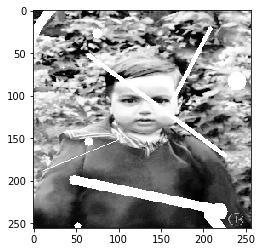

In [19]:
mask = random_mask(256, 256)[:,:,0]
plt.imshow(y_img * mask + (1-mask), cmap = 'gray')

In [37]:
idx2name = {}
name2idx = {}
masks_test = []
for i in range(n):
    im = cv2.cvtColor(cv2.imread(DATASET[1] + str(i) + '.png'), cv2.COLOR_RGB2GRAY)
    for j in range(y_test.shape[0]):
        if np.linalg.norm(im/255 - y_test[j, :, :, 0]) < 0.001:
            idx2name[i] = j
            name2idx[j] = i
x_test_real = []
for i in range(y_test.shape[0]):
    img = cv2.cvtColor(cv2.imread(DATASET[0] + str(name2idx[i]) + '.png'), cv2.COLOR_RGB2GRAY) / 255
    x_test_real += [img]
    mask = (np.abs(255 * img - cv2.cvtColor(cv2.imread(DATASET[1] + str(i) + '.png'), cv2.COLOR_RGB2GRAY)) < 0.5)* 1
    masks_test += [mask]
x_test_real = np.array(x_test_real)[:, :, :, np.newaxis]
masks_test = np.array(masks_test)[:, :, :, np.newaxis]

In [38]:
idx2name = {}
name2idx = {}
masks_train = []
for i in range(n):
    im = cv2.cvtColor(cv2.imread(DATASET[1] + str(i) + '.png'), cv2.COLOR_RGB2GRAY)
    for j in range(y_train.shape[0]):
        if np.linalg.norm(im/255 - y_train[j, :, :, 0]) < 0.001:
            idx2name[i] = j
            name2idx[j] = i
x_train_real = []
for i in range(y_train.shape[0]):
    img = cv2.cvtColor(cv2.imread(DATASET[0] + str(name2idx[i]) + '.png'), cv2.COLOR_RGB2GRAY) / 255
    x_train_real += [img]
    mask = (np.abs(255 * img - cv2.cvtColor(cv2.imread(DATASET[1] + str(i) + '.png'), cv2.COLOR_RGB2GRAY)) < 0.5)* 1
    masks_train += [mask]
x_train_real = np.array(x_train_real)[:, :, :, np.newaxis]
masks_train = np.array(masks_train)[:, :, :, np.newaxis]

In [45]:
print('Training starting...')
nb_epoch = 500
epoch_change_toreal = 400
n_batches = int(np.ceil(x_train.shape[0] / batch_size))
n_display = 10
n_epoch_print = 200
for epoch in range(1, nb_epoch + 1):
    if epoch > nb_epoch:
        break
    batch_i = 0
    
    
    D_log_loss_a =0
    gen_total_loss_a =0
    gen_mae_a =0
    gen_log_loss_a =0
    
    print('Epoch {}'.format(epoch))
    start = time.time()
    #batch_per_epoch = int(n / batch_size)
    progbar = keras_generic_utils.Progbar(n_batches)
    for cond_imgs, imgs in tng_gen:
        #new cond_imgs every time:
        if epoch < epoch_change_toreal:
            mask_arr = []
            for i in range(imgs.shape[0]):
                mask_arr += [random_mask(im_width, im_height)[:,:,0]]
            mask_arr = np.array(mask_arr)
            mask_arr = mask_arr.reshape(imgs.shape)
            cond_imgs = imgs * mask_arr + (1 - mask_arr)
            
        if batch_i >= n_batches:
            break
        batch_i += 1
        # init the datasources again for each epoch
        #tng_gen = facades_generator(data_dir_name=data_path, data_type='training', im_width=im_width, batch_size=batch_size)
        #val_gen = facades_generator(data_dir_name=data_path, data_type='validation', im_width=im_width, batch_size=batch_size)

            # load a batch of decoded and original images
            # both for training and validation
            #X_train_decoded_imgs, X_train_original_imgs = next(tng_gen)
            #X_val_decoded_imgs, X_val_original_imgs = next(val_gen)

        # generate a batch of data and feed to the discriminator
        # some images that come out of here are real and some are fake
        # X is image patches for each image in the batch
        # Y is a 1x2 vector for each image. (means fake or not)
        #print('x, y for disc')
        X_discriminator, y_discriminator =  patch_utils.get_disc_batch(imgs,#patch_utils.get_disc_batch(imgs,
                                                          cond_imgs,
                                                          generator_nn,
                                                          patch_dim=sub_patch_dim,
                                                          nb_patches = nb_patch_patches)

        # Update the discriminator
        #print('calculating discriminator loss')
        disc_loss = discriminator_nn.train_on_batch([X_discriminator, cond_imgs], y_discriminator)

        # create a batch to feed the generator
        #X_gen_target, X_gen = next(patch_utils.gen_batch(X_train_original_imgs, X_train_decoded_imgs, batch_size))
        y_gen = np.zeros((imgs.shape[0], nb_patch_patches), dtype=np.uint8)

        # Freeze the discriminator
        discriminator_nn.trainable = False

        # trainining GAN
        #print('calculating GAN loss...')
        gen_loss = dc_gan_nn.train_on_batch(cond_imgs, [imgs, y_gen])

        # Unfreeze the discriminator
        discriminator_nn.trainable = True


        # print losses
        D_log_loss = disc_loss
        gen_total_loss = gen_loss[0].tolist()
        gen_total_loss = min(gen_total_loss, 1000000)
        gen_mae = gen_loss[1].tolist()
        gen_mae = min(gen_mae, 1000000)
        gen_log_loss = gen_loss[2].tolist()
        gen_log_loss = min(gen_log_loss, 1000000)
        
        
        D_log_loss_a += D_log_loss/n_batches
        gen_total_loss_a += gen_total_loss/n_batches
        gen_mae_a += gen_mae/n_batches
        gen_log_loss_a += gen_log_loss/n_batches

        progbar.update(batch_i, values=[("Dis logloss", D_log_loss),
                                        ("Gen total", gen_total_loss),
                                        ("Gen L1 (mae)", gen_mae),
                                        ("Gen logloss", gen_log_loss)])
        
        # ---------------------------
        # Save images for visualization every 2nd batch
        #if batch_counter % 2 == 0:

            # print images for training data progress
         #   logger.plot_generated_batch(X_train_original_imgs, X_train_decoded_imgs, generator_nn, epoch, 'tng', mini_batch_i)

            # print images for validation data
          #  X_full_val_batch, X_sketch_val_batch = next(patch_utils.gen_batch(X_val_original_imgs, X_val_decoded_imgs, batch_size))
           # logger.plot_generated_batch(X_full_val_batch, X_sketch_val_batch, generator_nn, epoch, 'val', mini_batch_i)

        # -----------------------
        # log epoch

    D_log_loss_h += [D_log_loss_a]
    gen_total_loss_h += [gen_total_loss_a]
    gen_mae_h +=[gen_mae_a]
    gen_log_loss_h +=[gen_log_loss_a]
    
    if epoch % 10 == 0:
        dc_gan_nn.save_weights('../trained_models/patch64_rand.h5')
        with open('../model_data/patch64_rand.pkl', 'wb') as f:
            pickle.dump((D_log_loss_h,gen_total_loss_h, gen_mae_h, gen_log_loss_h), f)
    
    print("")
    print('Epoch %s/%s, Time: %s' % (epoch, nb_epoch, time.time() - start))

    
    #imgs_fake_display = generator_nn.predict(imgs_cond_display, batch_size = n_display)
    #plt.figure(figsize = (10, 50))
    #for i in range(n_display):
    #    plt.subplot(n_display, 3, 3 * i + 1)
    #    plt.imshow(127.5 * (imgs_cond_display[i, :, :, 0] + 1), cmap='gray')
    ##    plt.subplot(n_display, 3, 3 * i + 2)
     #   plt.imshow(127.5 * (imgs_display[i, :, :, 0] + 1), cmap='gray')
     #   plt.subplot(n_display, 3, 3 * i + 3)
     #   plt.imshow(127.5 * (imgs_fake_display[i, :, :, 0] + 1), cmap='gray')
    epoch = epoch + 1
    if epoch % n_epoch_print == 0:
        directory = '../model_data64/images_' + str(len(D_log_loss_h)) + '_epochs/'
        if not os.path.exists(directory + 'train'):
            os.makedirs(directory + 'train')
        if not os.path.exists(directory + 'test'):
            os.makedirs(directory + 'test')
        cond_imgs = masks_train[:n_display, :, :, :]  + \
            (1 - masks_train[:n_display, :, :, :]) * y_train[:n_display, :, :, :]
        imgs_fake = generator_nn.predict(cond_imgs)
        #plt.close('all')
        #plt.figure(figsize = (40, 50))
        for i in range(n_display):
            #plt.subplot(n_display, 3, 1 + 3 * i)
            cv2.imwrite(directory + 'train/' + str(i) + '_damaged.png', 
                        cv2.cvtColor((255 * x_train[i, :, :, 0]).astype('uint8'), 8))
            #plt.imshow(cond_imgs[i, :, :, 0], cmap = 'gray')
            #plt.subplot(n_display, 3, 2 + 3 * i)
            cv2.imwrite(directory + 'train/' + str(i) + '_original.png',
                        cv2.cvtColor((255 * y_train[i, :, :, 0]).astype('uint8'), 8))
            #plt.imshow(y_train[i, :, :, 0], cmap = 'gray')
            #plt.subplot(n_display, 3, 3 + 3 * i)
            cv2.imwrite(directory + 'train/' + str(i) + '_generated.png', 
                        cv2.cvtColor((255 * imgs_fake[i, :, :, 0]).astype('uint8'), 8))
            #plt.imshow(imgs_fake[i, :, :, 0], cmap = 'gray') 
        cond_imgs = masks_test[:n_display, :, :, :]  + \
            (1 - masks_test[:n_display, :, :, :]) * y_test[:n_display, :, :, :]
        imgs_fake = generator_nn.predict(cond_imgs)
        #plt.close('all')
        #plt.figure(figsize = (40, 50))
        for i in range(n_display):
            #plt.subplot(n_display, 3, 1 + 3 * i)
            cv2.imwrite(directory + 'test/' + str(i) + '_damaged.png', 
                        cv2.cvtColor((255 * x_test[i, :, :, 0]).astype('uint8'), 8))
            #plt.imshow(cond_imgs[i, :, :, 0], cmap = 'gray')
            #plt.subplot(n_display, 3, 2 + 3 * i)
            cv2.imwrite(directory + 'test/' + str(i) + '_original.png',
                        cv2.cvtColor((255 * y_test[i, :, :, 0]).astype('uint8'), 8))
            #plt.imshow(y_test[i, :, :, 0], cmap = 'gray')
            #plt.subplot(n_display, 3, 3 + 3 * i)
            cv2.imwrite(directory + 'test/' + str(i) + '_generated.png', 
                        cv2.cvtColor((255 * imgs_fake[i, :, :, 0]).astype('uint8'), 8))
            #plt.imshow(imgs_fake[i, :, :, 0], cmap = 'gray')        

    # ------------------------------
    # save weights on every 2nd epoch
    #if epoch % 2 == 0:
    #    gen_weights_path = os.path.join('./pix2pix_out/weights/gen_weights_epoch_%s.h5' % (epoch))
    #    generator_nn.save_weights(gen_weights_path, overwrite=True)

    #    disc_weights_path = os.path.join('./pix2pix_out/weights/disc_weights_epoch_%s.h5' % (epoch))
    #    discriminator_nn.save_weights(disc_weights_path, overwrite=True)

     #   DCGAN_weights_path = os.path.join('./pix2pix_out/weights/DCGAN_weights_epoch_%s.h5' % (epoch))
     #   dc_gan_nn.save_weights(DCGAN_weights_path, overwrite=True)

Training starting...
Epoch 1


/home/shared/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0223 - Gen total: 2.5285 - Gen L1 (mae): 0.0252 - Gen logloss: 0.1376

Epoch 1/500, Time: 19.82566809654236
Epoch 2
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0180 - Gen total: 2.2986 - Gen L1 (mae): 0.0229 - Gen logloss: 0.0611

Epoch 2/500, Time: 19.7812020778656
Epoch 3
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0145 - Gen total: 2.2939 - Gen L1 (mae): 0.0229 - Gen logloss: 0.0993

Epoch 3/500, Time: 19.78867483139038
Epoch 4
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0263 - Gen total: 2.1839 - Gen L1 (mae): 0.0218 - Gen logloss: 0.0780

Epoch 4/500, Time: 19.79597234725952
Epoch 5
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0265 - Gen total: 2.3254 - Gen L1 (mae): 0.0232 - Gen logloss: 0.1256

Epoch 5/500, Time: 19.792547702789307
Epoch 6
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.

16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0055 - Gen total: 1.8272 - Gen L1 (mae): 0.0183 - Gen logloss: 0.0042

Epoch 87/500, Time: 19.848784923553467
Epoch 88
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0086 - Gen total: 2.0755 - Gen L1 (mae): 0.0208 - Gen logloss: 0.0024

Epoch 88/500, Time: 19.797206163406372
Epoch 89
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0112 - Gen total: 2.0880 - Gen L1 (mae): 0.0209 - Gen logloss: 0.0098

Epoch 89/500, Time: 19.83406901359558
Epoch 90
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0071 - Gen total: 1.8868 - Gen L1 (mae): 0.0189 - Gen logloss: 0.0108

Epoch 90/500, Time: 22.33134937286377
Epoch 91
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0068 - Gen total: 1.9379 - Gen L1 (mae): 0.0194 - Gen logloss: 0.0027

Epoch 91/500, Time: 19.873512983322144
Epoch 92
16/16 [==============================] - 20s 1s/step - Di

16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0227 - Gen total: 1.7985 - Gen L1 (mae): 0.0180 - Gen logloss: 0.0421

Epoch 173/500, Time: 19.742963790893555
Epoch 174
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0200 - Gen total: 1.8538 - Gen L1 (mae): 0.0185 - Gen logloss: 0.0131

Epoch 174/500, Time: 19.731834650039673
Epoch 175
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0222 - Gen total: 1.7908 - Gen L1 (mae): 0.0179 - Gen logloss: 0.0156

Epoch 175/500, Time: 19.757190465927124
Epoch 176
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0156 - Gen total: 1.9189 - Gen L1 (mae): 0.0192 - Gen logloss: 0.0090

Epoch 176/500, Time: 19.779845237731934
Epoch 177
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0127 - Gen total: 1.7804 - Gen L1 (mae): 0.0178 - Gen logloss: 0.0019

Epoch 177/500, Time: 19.7609806060791
Epoch 178
16/16 [==============================] - 20s 1s

16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0143 - Gen total: 1.8845 - Gen L1 (mae): 0.0188 - Gen logloss: 0.0032

Epoch 216/500, Time: 19.778931617736816
Epoch 217
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0081 - Gen total: 2.0134 - Gen L1 (mae): 0.0201 - Gen logloss: 0.0013

Epoch 217/500, Time: 19.757259130477905
Epoch 218
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0057 - Gen total: 1.7804 - Gen L1 (mae): 0.0178 - Gen logloss: 5.5728e-04

Epoch 218/500, Time: 19.75498080253601
Epoch 219
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0041 - Gen total: 1.7553 - Gen L1 (mae): 0.0176 - Gen logloss: 9.0459e-04

Epoch 219/500, Time: 19.77084755897522
Epoch 220
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0053 - Gen total: 1.8382 - Gen L1 (mae): 0.0184 - Gen logloss: 5.7657e-04

Epoch 220/500, Time: 22.103602409362793
Epoch 221
16/16 [============================

16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0040 - Gen total: 1.8996 - Gen L1 (mae): 0.0190 - Gen logloss: 3.1784e-04

Epoch 301/500, Time: 19.816811084747314
Epoch 302
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0038 - Gen total: 1.7582 - Gen L1 (mae): 0.0176 - Gen logloss: 7.3692e-04

Epoch 302/500, Time: 19.787886142730713
Epoch 303
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0067 - Gen total: 1.8049 - Gen L1 (mae): 0.0180 - Gen logloss: 0.0012

Epoch 303/500, Time: 19.766387462615967
Epoch 304
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0056 - Gen total: 1.7437 - Gen L1 (mae): 0.0174 - Gen logloss: 8.6129e-04

Epoch 304/500, Time: 19.84918713569641
Epoch 305
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0072 - Gen total: 1.7922 - Gen L1 (mae): 0.0179 - Gen logloss: 0.0033

Epoch 305/500, Time: 19.787859439849854
Epoch 306
16/16 [===========================

16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0063 - Gen total: 1.7630 - Gen L1 (mae): 0.0176 - Gen logloss: 9.2558e-04

Epoch 385/500, Time: 19.83652353286743
Epoch 386
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0059 - Gen total: 1.8944 - Gen L1 (mae): 0.0189 - Gen logloss: 0.0011

Epoch 386/500, Time: 19.788679599761963
Epoch 387
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0046 - Gen total: 1.9282 - Gen L1 (mae): 0.0193 - Gen logloss: 0.0046

Epoch 387/500, Time: 19.74685049057007
Epoch 388
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0075 - Gen total: 1.8246 - Gen L1 (mae): 0.0182 - Gen logloss: 9.8573e-04

Epoch 388/500, Time: 19.76040744781494
Epoch 389
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0143 - Gen total: 1.8148 - Gen L1 (mae): 0.0181 - Gen logloss: 0.0484

Epoch 389/500, Time: 19.75517463684082
Epoch 390
16/16 [==============================] - 

16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0059 - Gen total: 2.1653 - Gen L1 (mae): 0.0217 - Gen logloss: 0.0025

Epoch 428/500, Time: 19.77830219268799
Epoch 429
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0064 - Gen total: 2.1488 - Gen L1 (mae): 0.0215 - Gen logloss: 0.0055

Epoch 429/500, Time: 19.721296787261963
Epoch 430
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0076 - Gen total: 2.1457 - Gen L1 (mae): 0.0215 - Gen logloss: 9.3491e-04

Epoch 430/500, Time: 22.010990619659424
Epoch 431
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0054 - Gen total: 2.1264 - Gen L1 (mae): 0.0213 - Gen logloss: 0.0014

Epoch 431/500, Time: 19.74503993988037
Epoch 432
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0046 - Gen total: 2.1363 - Gen L1 (mae): 0.0214 - Gen logloss: 0.0013

Epoch 432/500, Time: 19.72854208946228
Epoch 433
16/16 [==============================] - 20s

16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0061 - Gen total: 2.0182 - Gen L1 (mae): 0.0202 - Gen logloss: 0.0011

Epoch 471/500, Time: 19.737120151519775
Epoch 472
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0062 - Gen total: 2.0683 - Gen L1 (mae): 0.0207 - Gen logloss: 0.0011

Epoch 472/500, Time: 19.738089561462402
Epoch 473
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0075 - Gen total: 1.9797 - Gen L1 (mae): 0.0198 - Gen logloss: 0.0044

Epoch 473/500, Time: 19.764708042144775
Epoch 474
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0071 - Gen total: 1.9978 - Gen L1 (mae): 0.0200 - Gen logloss: 0.0021

Epoch 474/500, Time: 19.76869297027588
Epoch 475
16/16 [==============================] - 20s 1s/step - Dis logloss: 0.0074 - Gen total: 1.9844 - Gen L1 (mae): 0.0198 - Gen logloss: 0.0017

Epoch 475/500, Time: 19.73636293411255
Epoch 476
16/16 [==============================] - 20s 1s

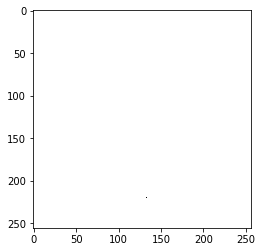

In [34]:
plt.imshow(masks_test[3, :, :, 0], cmap = 'gray')

In [128]:
import pickle
with open('../model_data/patch64_rand.pkl', 'wb') as f:
    pickle.dump((D_log_loss_h,gen_total_loss_h, gen_mae_h, gen_log_loss_h), f)

In [129]:
dc_gan_nn.save_weights('../trained_models/patch64_rand_dc_gan.h5')

In [130]:
X_discriminator, y_discriminator =  patch_utils.get_disc_batch(imgs,#patch_utils.get_disc_batch(imgs,
                                                          cond_imgs,
                                                          generator_nn,
                                                          patch_dim=sub_patch_dim,
                                                          nb_patches = nb_patch_patches)

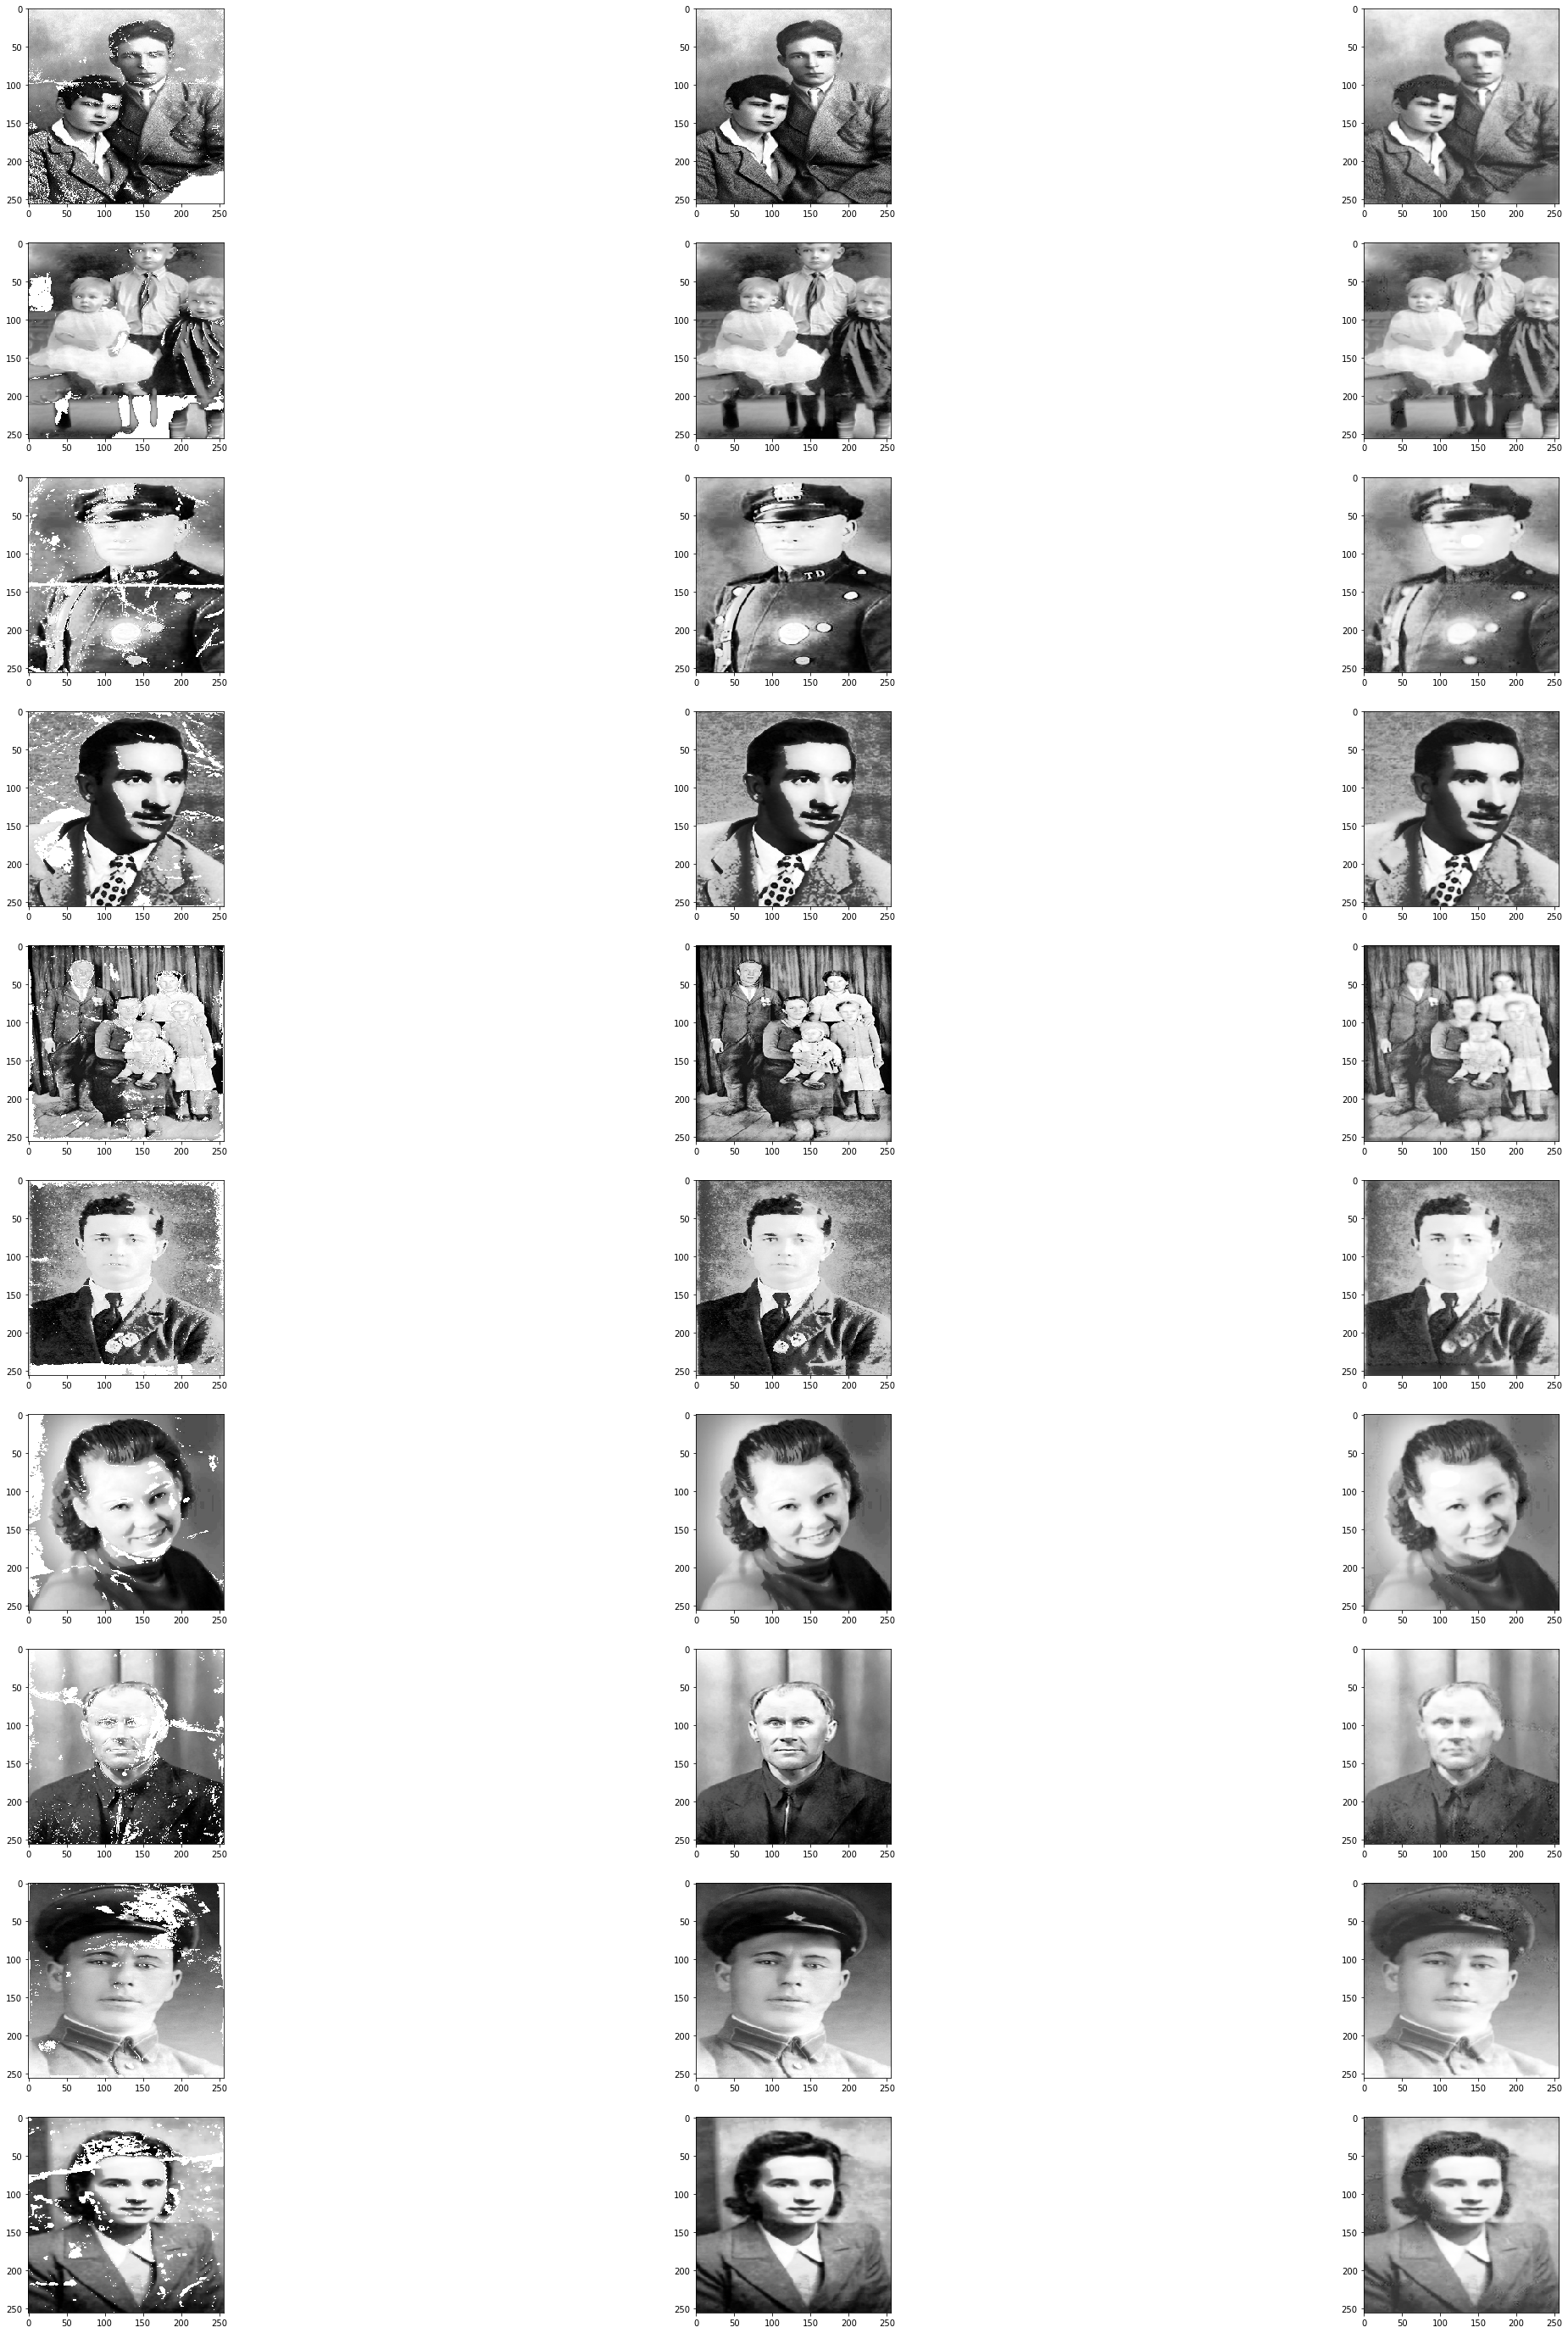

In [46]:
n_display = 10
imgs_fake = generator_nn.predict(x_train[:n_display, :, :, :])
plt.close('all')
plt.figure(figsize = (40, 50))
for i in range(n_display):
    plt.subplot(n_display, 3, 1 + 3 * i)
    #cv2.imwrite('../model_data/images_'+str(epochs_passed) + '_epochs/train/' + str(i) + '_damaged.png', 
    #            cv2.cvtColor((255 * x_train[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(x_train[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 3, 2 + 3 * i)
    #cv2.imwrite('../model_data/images_'+str(epochs_passed) + '_epochs/train/' + str(i) + '_original.png',
    #            cv2.cvtColor((255 * y_train[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(y_train[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 3, 3 + 3 * i)
    #cv2.imwrite('../model_data/images_'+str(epochs_passed) + '_epochs/train/' + str(i) + '_generated.png', 
    #            cv2.cvtColor((255 * imgs_fake[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(imgs_fake[i, :, :, 0], cmap = 'gray')

In [136]:
idx2name = {}
name2idx = {}
for i in range(n):
    im = cv2.cvtColor(cv2.imread('../Data/y_scaled/' + str(i) + '.png'), cv2.COLOR_RGB2GRAY)
    for j in range(y_test.shape[0]):
        if np.linalg.norm(im/255 - y_test[j, :, :, 0]) < 0.001:
            idx2name[i] = j
            name2idx[j] = i
x_test_real = []
for i in range(y_test.shape[0]):
    mask = cv2.cvtColor(cv2.imread('../Data/y_masked/' + str(name2idx[i]) + '.png'), cv2.COLOR_RGB2GRAY) / 255
    x_test_real += [mask]
x_test_real = np.array(x_test_real)[:, :, :, np.newaxis]

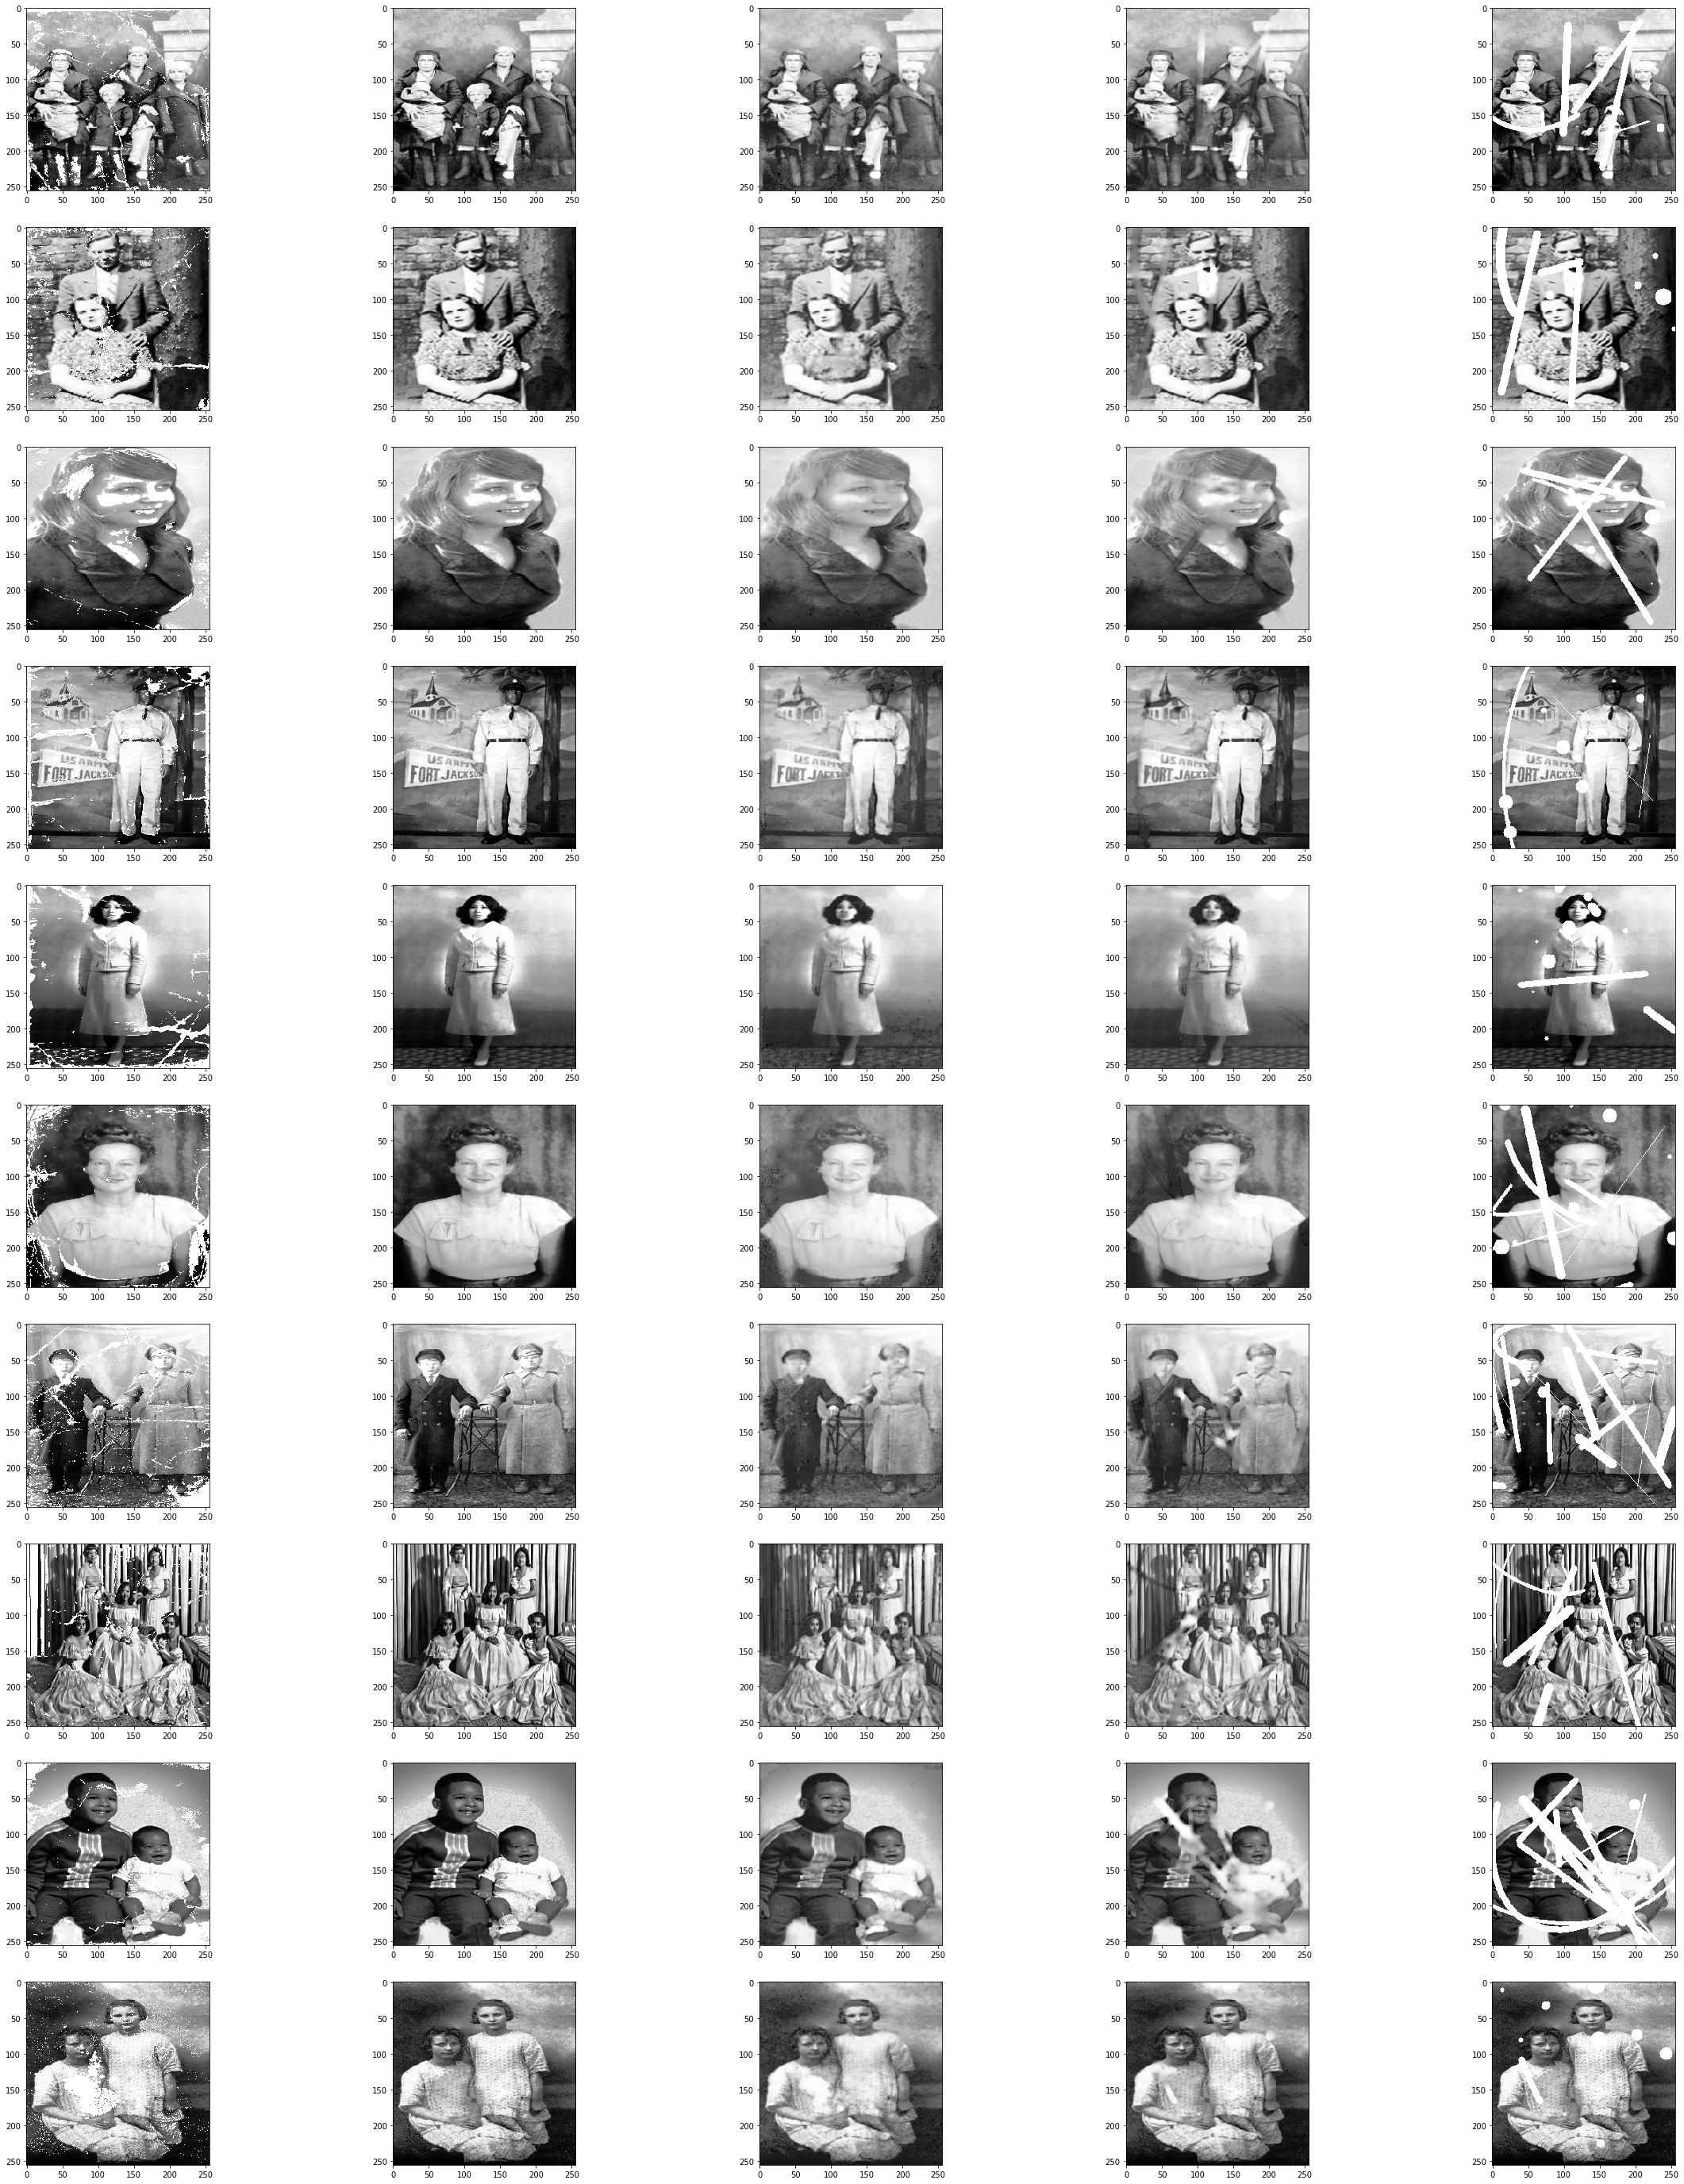

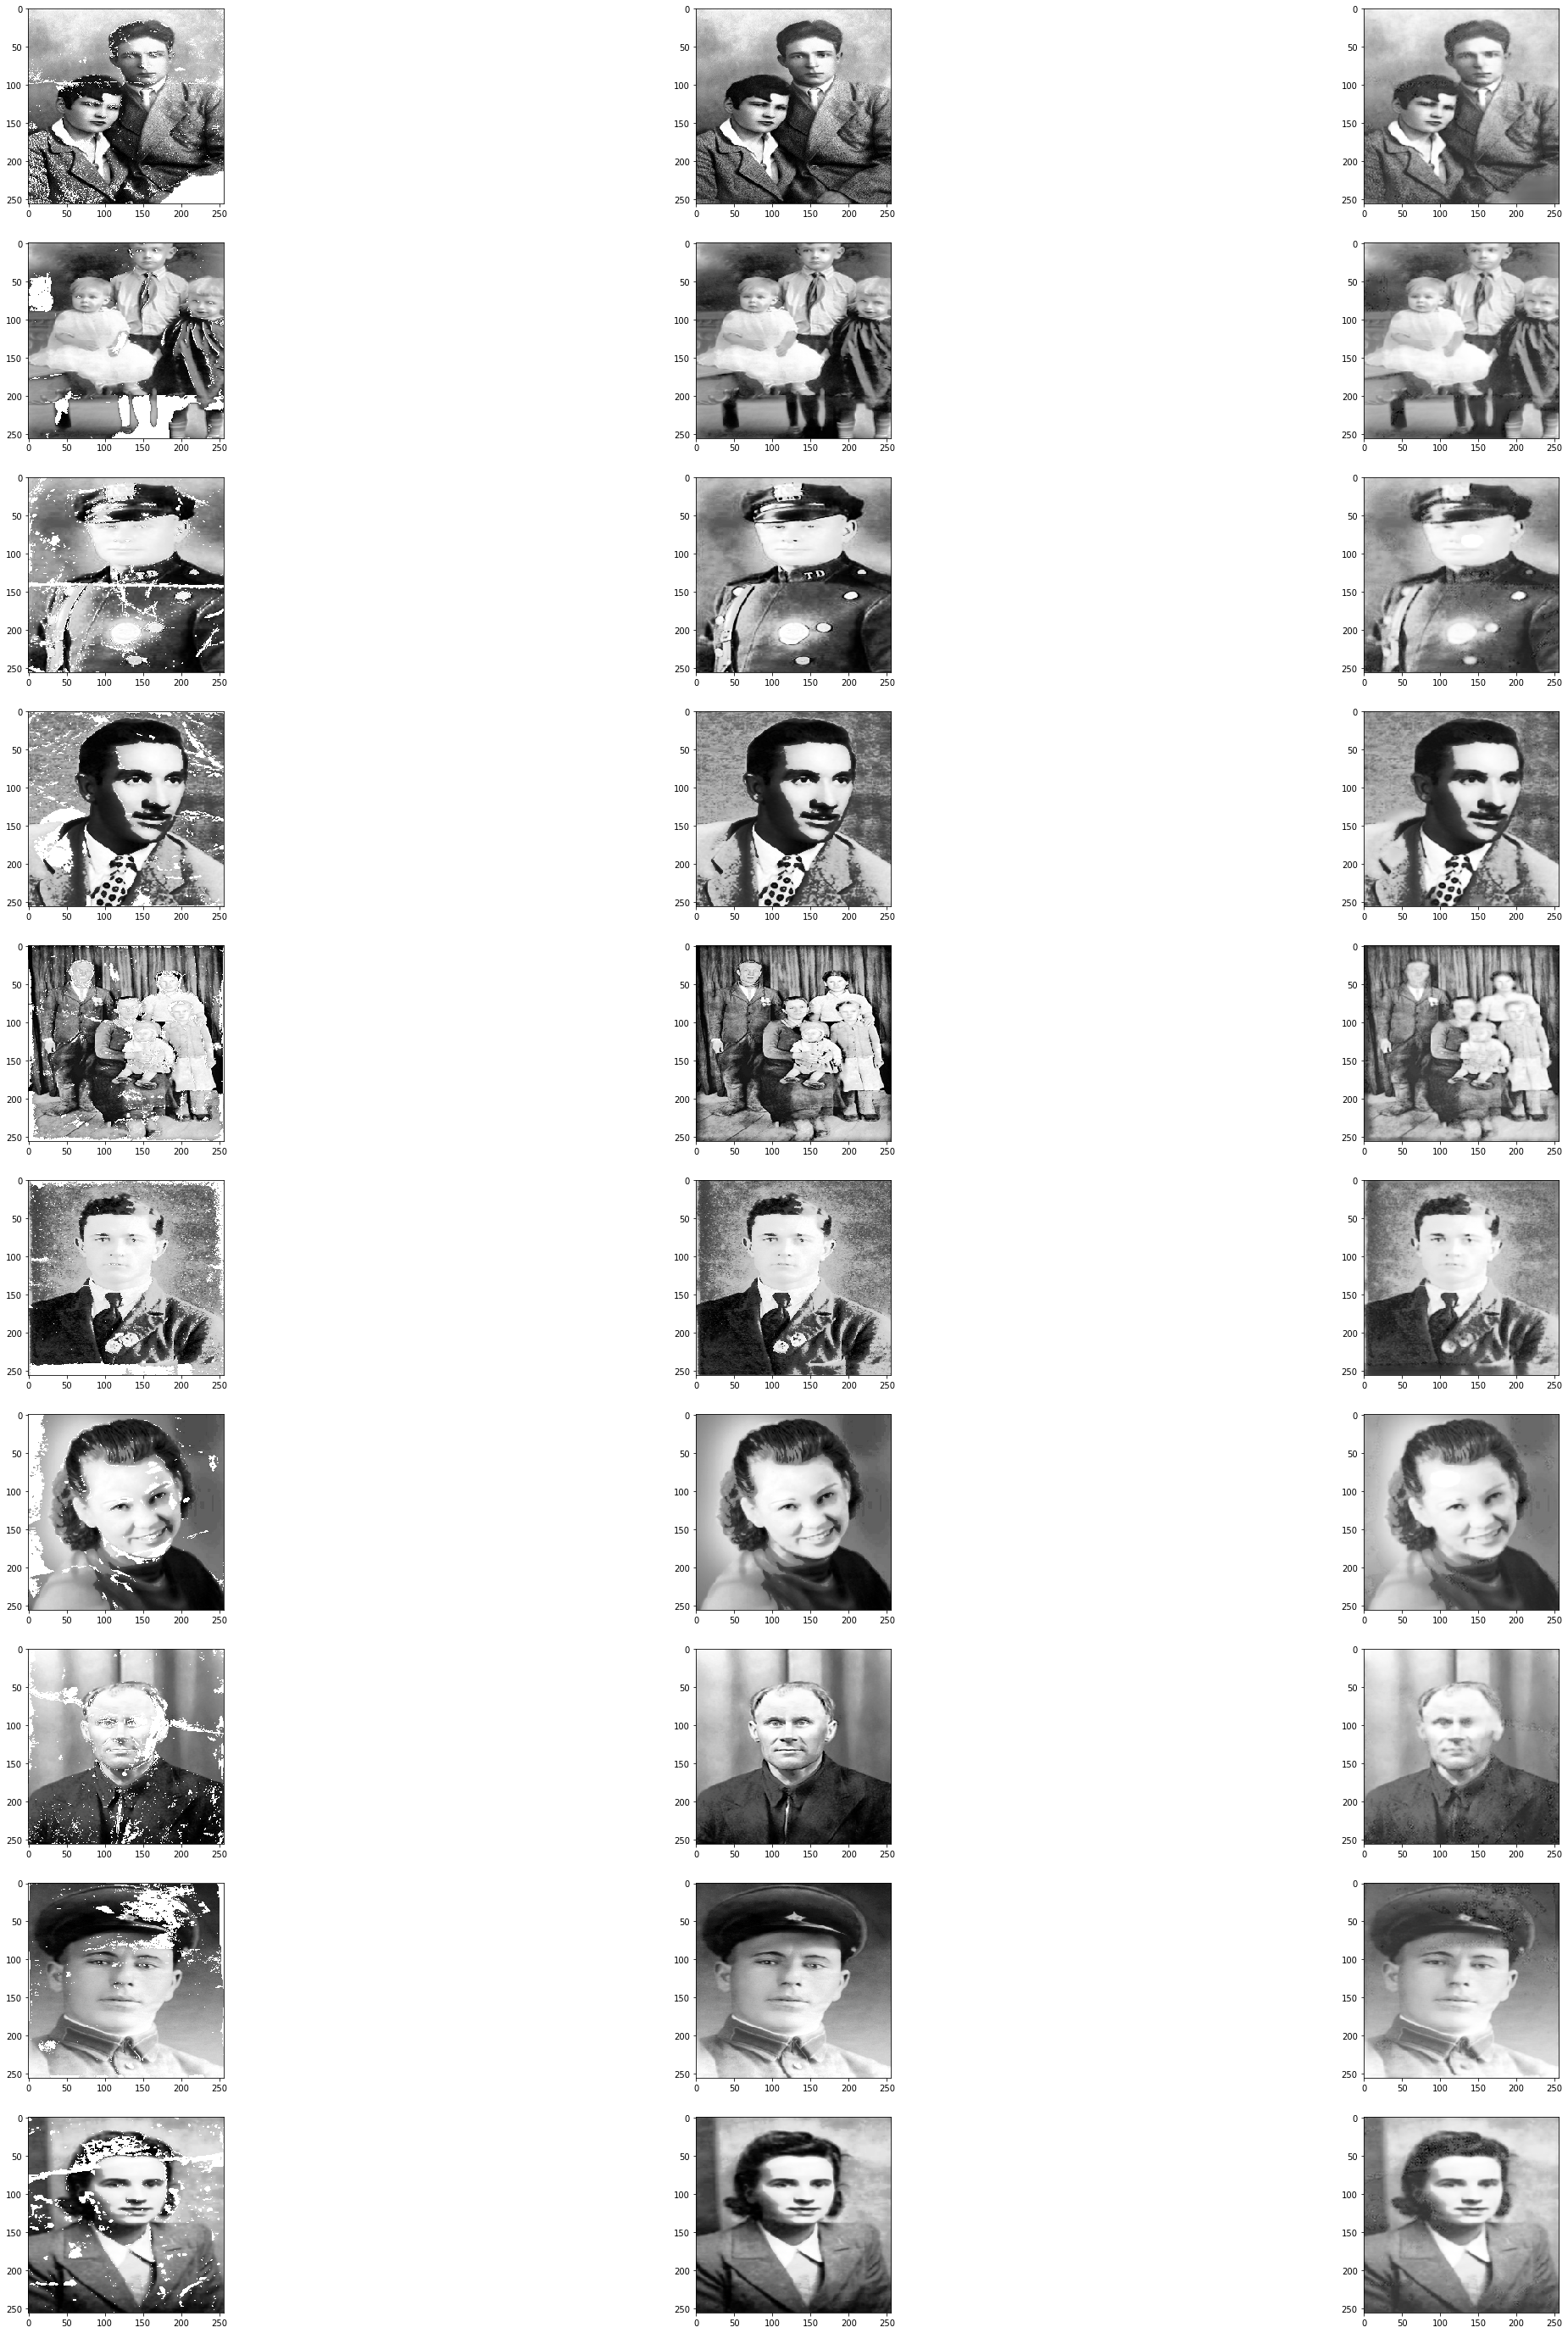

In [51]:
n_display = 10
imgs = y_test[:n_display, :, :, :]
mask_arr = []
for i in range(imgs.shape[0]):
    mask_arr += [random_mask(im_width, im_height)[:,:,0]]
mask_arr = np.array(mask_arr)
mask_arr = mask_arr.reshape(imgs.shape)
cond_imgs = imgs * mask_arr + (1 - mask_arr)
imgs_fake = generator_nn.predict(x_test_real[:n_display, :, :, :])
imgs_fake2 = generator_nn.predict(cond_imgs)
plt.close('all')
plt.figure(figsize = (40, 50))
epochs_passed = len(D_log_loss_h) + 2

directory = '../model_data64/images_' + str(len(D_log_loss_h)) + '_epochs/'
if not os.path.exists(directory + 'train'):
    os.makedirs(directory + 'train')
if not os.path.exists(directory + 'test'):
    os.makedirs(directory + 'test')
for i in range(n_display):
    plt.subplot(n_display, 5, 1 + 5 * i)
    cv2.imwrite(directory + 'test/' + str(i) + '_damaged.png', 
                cv2.cvtColor((255 * x_test_real[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(x_test_real[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 5, 2 + 5 * i)
    cv2.imwrite(directory + 'test/' + str(i) + '_original.png', 
                cv2.cvtColor((255 * y_test[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(y_test[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 5, 3 + 5 * i)
    cv2.imwrite(directory + 'test/' + str(i) + '_generated.png', 
                cv2.cvtColor((255 * imgs_fake[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(imgs_fake[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 5, 4 + 5 * i)
    cv2.imwrite(directory + 'test/' + str(i) + '_generated2.png', 
                cv2.cvtColor((255 * imgs_fake2[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(imgs_fake2[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 5, 5 + 5 * i)
    cv2.imwrite(directory + 'test/' + str(i) + '_damaged2.png', 
                cv2.cvtColor((255 * cond_imgs[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(cond_imgs[i, :, :, 0], cmap = 'gray')
plt.show()
    

plt.figure(figsize = (40, 50))
imgs_fake = generator_nn.predict(x_train[:n_display, :, :, :])
for i in range(n_display):
    plt.subplot(n_display, 3, 1 + 3 * i)
    cv2.imwrite('../model_data/images_'+str(epochs_passed) + '_epochs/train/' + str(i) + '_damaged.png', 
                cv2.cvtColor((255 * x_train[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(x_train[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 3, 2 + 3 * i)
    cv2.imwrite('../model_data/images_'+str(epochs_passed) + '_epochs/train/' + str(i) + '_original.png',
                cv2.cvtColor((255 * y_train[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(y_train[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 3, 3 + 3 * i)
    cv2.imwrite('../model_data/images_'+str(epochs_passed) + '_epochs/train/' + str(i) + '_generated.png', 
                cv2.cvtColor((255 * imgs_fake[i, :, :, 0]).astype('uint8'), 8))
    plt.imshow(imgs_fake[i, :, :, 0], cmap = 'gray')

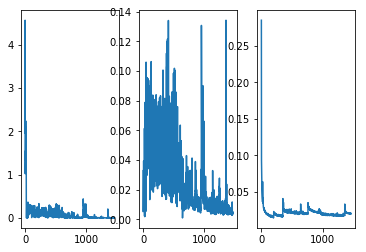

In [48]:
plt.figure()
plt.subplot(1, 3, 1)
plt.plot(gen_log_loss_h)
plt.subplot(1, 3, 2)
plt.plot(D_log_loss_h)
plt.subplot(1, 3, 3)
plt.plot(gen_mae_h)
plt.show()

In [118]:
len(D_log_loss_h)

250

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


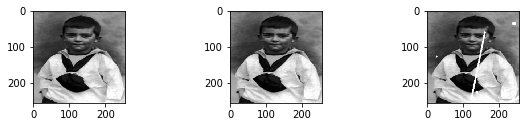

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


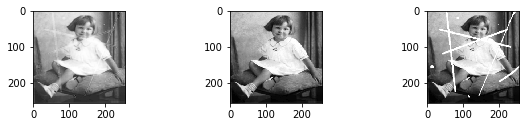

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


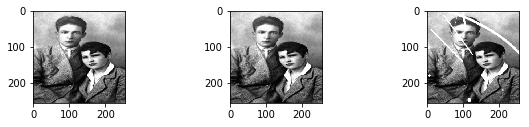

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


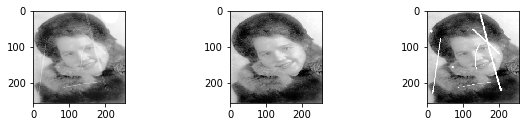

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


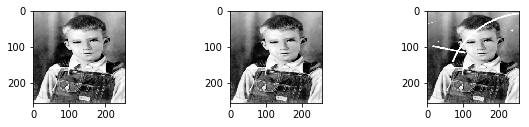

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


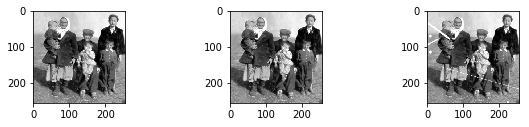

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


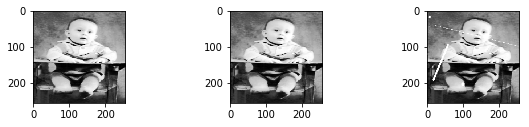

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


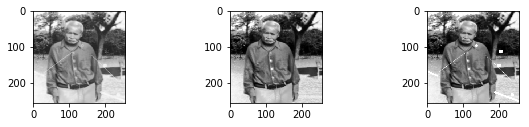

In [66]:
n_display = 10
imgs_fake = generator_nn.predict(x_train[:n_display, :, :, :])
plt.close('all')
plt.figure(figsize = (3, 5))
for i in range(8):
    print(y_discriminator[i, :])
    plt.figure(figsize = (10, 20))
    plt.subplot(n_display, 3, 1 + 3 * i)
    plt.imshow(X_discriminator[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 3, 2 + 3 * i)
    plt.imshow(imgs[i, :, :, 0], cmap = 'gray')
    plt.subplot(n_display, 3, 3 + 3 * i)
    plt.imshow(cond_imgs[i, :, :, 0], cmap = 'gray')
    plt.show()

In [40]:
y_discriminator.shape

(8, 16)

True

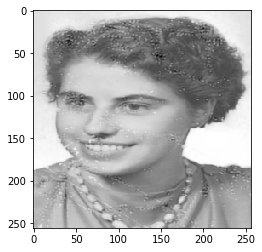

In [35]:
#i = 2

DATASET = ['../../../Data/unsplit/y_masked/', '../../../Data/unsplit/y_scaled/']
i = 18
img = np.array(Image.open(DATASET[0] + str(2) + '.png').convert('L')) / 255

img = cv2.resize(img, (256, 256))

imgs_fake = generator_nn.predict(img[np.newaxis, :, :, np.newaxis])

plt.imshow(imgs_fake[0, :, :, 0], cmap = 'gray')
cv2.imwrite('daria_reconstruct64x64.png', cv2.cvtColor((255 * imgs_fake[0, :, :, 0]).astype('uint8'), cv2.COLOR_GRAY2RGB))

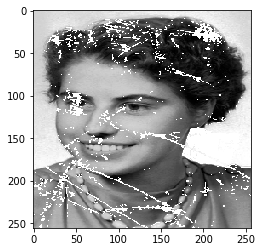

In [36]:

plt.imshow(img, cmap = 'gray')